# INTRODUCTION

### This Notebook experiments with 2 different Cats vs. Dogs datasets with a combination of different models. 
1. A simple Deep Learning model with a few combinations of 2D Convolutional layers and MaxPooling layers.
2. A Combination of a Data Augmentation layer and the previous simple DL model, where the DA layer performs various augmentation (i.e. Random flips, rotations, zoom, contrast, etc.) to the image data on the fly to extend the range of patterns that can be learned from the dataset.
3. A simple implementation of Transfer Learning with the use of the inbuilt Keras Application of Efficient Net B0. The model is used out of the box with almost no fine-tuning required for the binary classification use case.
4. A quick experimentation with the combination of the Data Augmentation layer and the Transfer Learning model.

# Import Libraries

In [7]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,mixed_precision
from shutil import copyfile, move, rmtree
from tqdm import tqdm

# Explore Dataset 1: [Microsoft Cats vs. Dogs ](http://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset)

In [8]:
targetPath = "../input/microsoft-catsvsdogs-dataset/PetImages"
dogPath = "../input/microsoft-catsvsdogs-dataset/PetImages/Dog"
catPath = "../input/microsoft-catsvsdogs-dataset/PetImages/Cat"

In [9]:
def plot_random_image(target_dir, sample = 5):
    
    target_class=random.choice(os.listdir(target_dir))
    target_folder=os.path.join(target_dir,target_class)
    random_image=random.sample(os.listdir(target_folder),sample)
 
    plt.figure(figsize=(16,5))
    for i in range(sample):
        
        plt.subplot(1,sample,i+1)
        img=tf.io.read_file(os.path.join(target_folder,random_image[i]))
        img=tf.io.decode_image(img)
        plt.imshow(img)
        plt.title(f'Class: {target_class}\nShape: {img.shape}')
        plt.axis(False) 

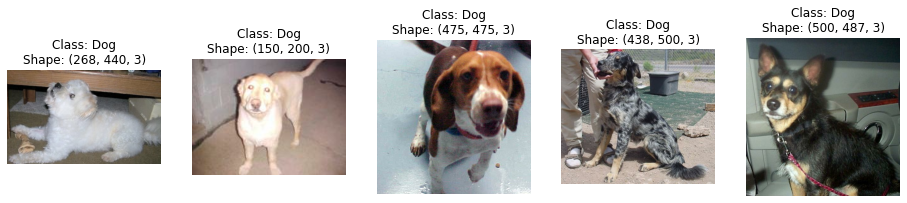

In [10]:
plot_random_image(targetPath)

In [11]:
def walkthrough(dir_name):
    for dirpath, dirnames, filenames in os.walk(dir_name):
        print(f"there are {len(dirnames)} directories in '{dirpath.split(sep='/')[-1]}' and {len(filenames)} images")

In [12]:
walkthrough(targetPath)

there are 2 directories in 'PetImages' and 0 images
there are 0 directories in 'Dog' and 12501 images
there are 0 directories in 'Cat' and 12501 images


**Both classes are in balance with an equal number of images. In case of an Inbalance, Data of the minority class can be augmented or based on the context, over-sampling or under-sampling can be done.**

# Split the data

In [13]:
def train_test_images(targetPath, path_to_split_data, split_ratio = 0.8):
    
    path_to_split_data_train = os.path.join(path_to_split_data,'train')
    path_to_split_data_test = os.path.join(path_to_split_data,'test')
    
    #make necessary folder and sub-folders
    if os.path.exists(path_to_split_data):
        rmtree(path_to_split_data)
    os.mkdir(path_to_split_data)
    
    os.mkdir(path_to_split_data_train)
    os.mkdir(path_to_split_data_test)
    
    #read and append train and test images for each class (sub-folders)
    for label in os.listdir(targetPath):
        files = os.listdir(os.path.join(targetPath, label))
        images = []
        for file in files:
            try:
                img = tf.io.read_file(os.path.join(targetPath, label, file))
                img = tf.image.decode_image(img)
                
                if img.ndim == 3:
                    images.append(file)
            except:
                pass
        
        #shuffle and split
        random.shuffle(images)
        size = len(images)
        split = int(split_ratio * size)
        
        os.mkdir(os.path.join(path_to_split_data_train,label))
        os.mkdir(os.path.join(path_to_split_data_test,label))
        
        """
        Either move or copy the split data from the target path. 
        Move saves memory. Copying a lots of images takes a while, 
        Funtion is defaulted to move. 
        
        edit: Kaggle doesn't allow moving of data from one directory to another,
        i.e. from input dir to working dir, only copying is allowed. 
        
        Therefore the function is limited to only copy
        
        """
        
        #train images
        print('Populating Train Images for', label)
        for i in range(split):
            train_src = os.path.join(targetPath, label, images[i])
            train_dst = os.path.join(path_to_split_data_train, label, images[i])
            copyfile(train_src, train_dst)
        
        #test images
        print('Populating Test Images for',label)
        for i in range(split, size):
            test_src = os.path.join(targetPath, label, images[i])
            test_dst = os.path.join(path_to_split_data_test, label, images[i])
            copyfile(test_src, test_dst)
    print('\n\nSplit complete!')
    return path_to_split_data_train, path_to_split_data_test

In [14]:
path_to_split_data = './data'
train_dir, test_dir = train_test_images(targetPath, path_to_split_data, split_ratio = 0.8)

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Cleanup called...
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Cleanup called...
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Cleanup called...
Cleanup called...


Populating Train Images for Dog
Populating Test Images for Dog


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


Populating Train Images for Cat
Populating Test Images for Cat


Split complete!


In [15]:
walkthrough(train_dir)

there are 2 directories in 'train' and 0 images
there are 0 directories in 'Cat' and 9980 images
there are 0 directories in 'Dog' and 9972 images


In [16]:
walkthrough(test_dir)

there are 2 directories in 'test' and 0 images
there are 0 directories in 'Cat' and 2495 images
there are 0 directories in 'Dog' and 2493 images


# Basic Preprocessing and Prefetching

In [17]:
img_size = (224,224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir, label_mode='binary', image_size=img_size)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode='binary', image_size=img_size, shuffle=False)

Found 19952 files belonging to 2 classes.
Found 4988 files belonging to 2 classes.


In [18]:
class_names = train_data.class_names
class_names

['Cat', 'Dog']

In [19]:
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
EPOCHS = 5
OPTIMIZER = keras.optimizers.Adam()
LOSS_FN = tf.keras.losses.binary_crossentropy

# 1. Basic DL model

In [21]:
simple_DL_model = tf.keras.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

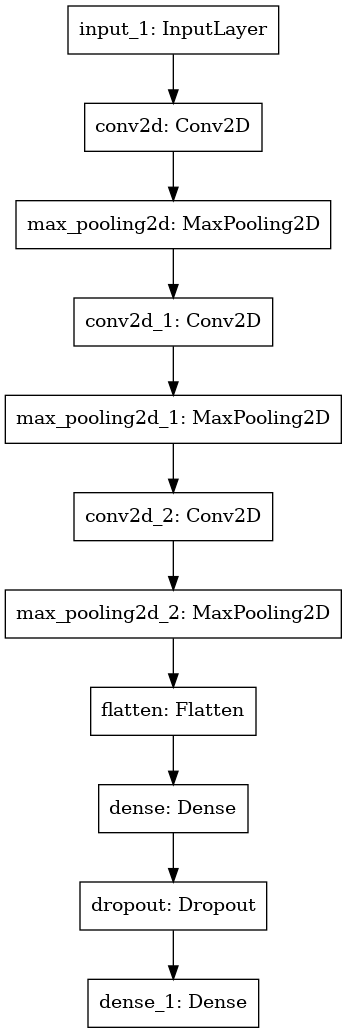

In [22]:
tf.keras.utils.plot_model(simple_DL_model)

In [23]:
simple_DL_model.compile(optimizer=OPTIMIZER, loss=LOSS_FN, metrics=['accuracy'])

In [24]:
simple_DL_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0

In [25]:
history_simple_model = simple_DL_model.fit(train_data, epochs=EPOCHS, steps_per_epoch=int(0.2*len(train_data)), 
                                           validation_data=test_data, validation_steps=len(test_data))

Epoch 1/5


2023-01-04 15:34:38.482336: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-04 15:34:41.170128: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 26/124 [=====>........................] - ETA: 6s - loss: 109.8650 - accuracy: 0.5012

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 86/124 [===================>..........] - ETA: 2s - loss: 33.6988 - accuracy: 0.5251

Cleanup called...


124/124 [==============================] - ETA: 0s - loss: 23.5858 - accuracy: 0.5239

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Cleanup called...


124/124 [==============================] - 30s 123ms/step - loss: 23.5858 - accuracy: 0.5239 - val_loss: 0.6928 - val_accuracy: 0.5235
Epoch 2/5
 47/124 [==========>...................] - ETA: 4s - loss: 0.6933 - accuracy: 0.5033

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 97/124 [======================>.......] - ETA: 1s - loss: 0.6919 - accuracy: 0.5168

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


104/124 [========================>.....] - ETA: 1s - loss: 0.6911 - accuracy: 0.5195

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


124/124 [==============================] - ETA: 0s - loss: 0.6947 - accuracy: 0.5260

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Cleanup called...


124/124 [==============================] - 15s 120ms/step - loss: 0.6947 - accuracy: 0.5260 - val_loss: 0.6921 - val_accuracy: 0.5383
Epoch 3/5
 21/124 [====>.........................] - ETA: 7s - loss: 0.6905 - accuracy: 0.5387

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 57/124 [============>.................] - ETA: 4s - loss: 0.6896 - accuracy: 0.5466

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 92/124 [=====================>........] - ETA: 2s - loss: 0.6919 - accuracy: 0.5448

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


115/124 [==========================>...] - ETA: 0s - loss: 0.6912 - accuracy: 0.5459

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


124/124 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.5391

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Cleanup called...


124/124 [==============================] - 15s 124ms/step - loss: 0.6925 - accuracy: 0.5391 - val_loss: 0.6901 - val_accuracy: 0.5289
Epoch 4/5
 10/124 [=>............................] - ETA: 6s - loss: 0.6884 - accuracy: 0.5188

Cleanup called...


 39/124 [========>.....................] - ETA: 4s - loss: 0.6901 - accuracy: 0.5280

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 52/124 [===========>..................] - ETA: 3s - loss: 0.6912 - accuracy: 0.5192

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


124/124 [==============================] - ETA: 0s - loss: 0.6923 - accuracy: 0.5121

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Cleanup called...


124/124 [==============================] - 15s 122ms/step - loss: 0.6923 - accuracy: 0.5121 - val_loss: 0.6904 - val_accuracy: 0.5024
Epoch 5/5
 14/124 [==>...........................] - ETA: 6s - loss: 0.6896 - accuracy: 0.5246

Cleanup called...


 50/124 [===========>..................] - ETA: 4s - loss: 0.6900 - accuracy: 0.5206

123/124 [============================>.] - ETA: 0s - loss: 0.6910 - accuracy: 0.5257

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Cleanup called...


124/124 [==============================] - 15s 119ms/step - loss: 0.6910 - accuracy: 0.5249 - val_loss: 0.6935 - val_accuracy: 0.5399


In [26]:
simple_DL_model_results = simple_DL_model.evaluate(test_data)

 20/156 [==>...........................] - ETA: 6s - loss: 0.6595 - accuracy: 0.3812

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


119/156 [=====================>........] - ETA: 1s - loss: 0.6847 - accuracy: 0.4900

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


150/156 [===========================>..] - ETA: 0s - loss: 0.6919 - accuracy: 0.5360

Cleanup called...


156/156 [==============================] - 7s 46ms/step - loss: 0.6935 - accuracy: 0.5399


In [27]:
simple_DL_model_results

[0.6934595108032227, 0.53989577293396]

In [28]:
def plot_loss_curves(history):
    
    '''
      returns seperate loss curves for training and validation metrics
    '''
    train_loss=history.history['loss']
    val_loss=history.history['val_loss']

    train_accuracy=history.history['accuracy']
    val_accuracy=history.history['val_accuracy']

    epochs=range(1,len(history.history['loss'])+1)
    plt.figure(figsize=(20,7))
    
  # plot loss 
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="training_loss")
    plt.plot(epochs,val_loss,label="validation_loss")
    plt.title("Loss curves")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()

  # plot accuracy 
    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label="training_acc")
    plt.plot(epochs,val_accuracy,label="validation_acc")
    plt.title("Accuracy curves")
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()

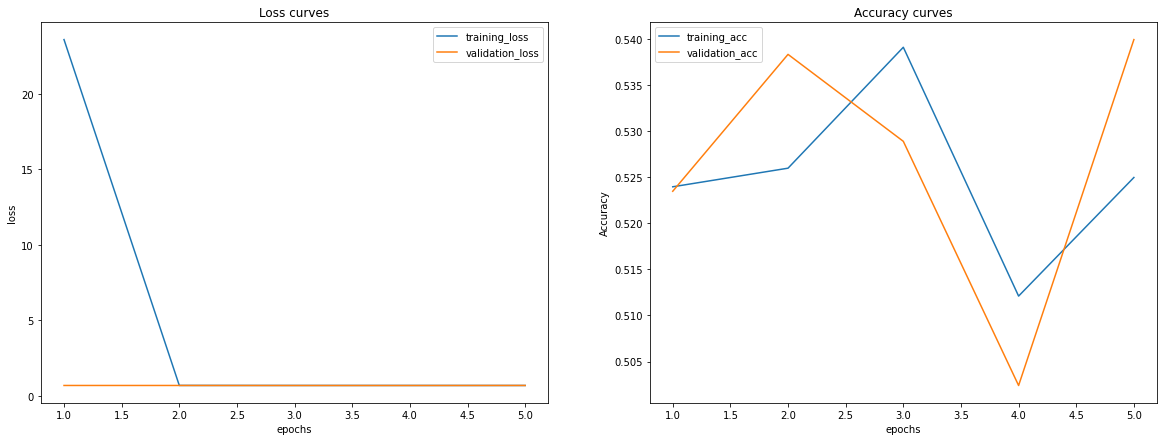

In [29]:
plot_loss_curves(history_simple_model)

# What is Data Augmentation? 

Data augmentation is a set of techniques to artificially increase the amount of data by generating new data points from existing data. This includes making small changes to data or using deep learning models to generate new data points. While this is used in cases of imbalanced or overall small dataset (due to cost associated with data collection or simply lack of data), its usage in Computer Vision problems allows for the model to see data in different perspectives (i.e. padding,random rotating,re-scaling,vertical and horizontal flipping and adding noise, etc.) to gain better understanding of the data and therefore, generalize better to new and unseen data. 

# 2. Simple model with a Sequential layer for Data Augmentation

In [30]:
img_aug_layer = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2,fill_mode='nearest'),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.Rescaling(scale=1.0/255)
], name='Image_Augmentation_Layer')

In [31]:
simple_DL_model_split = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
], name='Deep_Convolutional_Layer')

In [32]:
inputs = layers.Input(shape=(224, 224, 3), name='input_layer')

x = img_aug_layer(inputs)

x = simple_DL_model_split(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='Output_layer')(x)

simple_DL_model_img_aug = keras.Model(inputs,outputs,name='img_aug_dl_model')

In [33]:
simple_DL_model_img_aug.compile(optimizer=OPTIMIZER, loss=LOSS_FN, metrics=['accuracy'])

In [34]:
simple_DL_model_split.summary()

Model: "Deep_Convolutional_Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 86528)

In [35]:
simple_DL_model_img_aug.summary()

Model: "img_aug_dl_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
Image_Augmentation_Layer (Se (None, 224, 224, 3)       0         
_________________________________________________________________
Deep_Convolutional_Layer (Se (None, 1)                 22244929  
_________________________________________________________________
Output_layer (Dense)         (None, 1)                 2         
Total params: 22,244,931
Trainable params: 22,244,931
Non-trainable params: 0
_________________________________________________________________


In [36]:
history_simple_model_img_aug = simple_DL_model_img_aug.fit(train_data, epochs=EPOCHS, steps_per_epoch=int(0.2*len(train_data)), 
                                           validation_data=test_data, validation_steps=len(test_data))

Epoch 1/5
 25/124 [=====>........................] - ETA: 6s - loss: 0.6921 - accuracy: 0.4963

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 86/124 [===================>..........] - ETA: 2s - loss: 0.6930 - accuracy: 0.4949

Cleanup called...


124/124 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.4892

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Cleanup called...


124/124 [==============================] - 18s 135ms/step - loss: 0.6931 - accuracy: 0.4892 - val_loss: 0.6931 - val_accuracy: 0.4998
Epoch 2/5
 47/124 [==========>...................] - ETA: 4s - loss: 0.6932 - accuracy: 0.4794

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 97/124 [======================>.......] - ETA: 1s - loss: 0.6932 - accuracy: 0.4903

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


104/124 [========================>.....] - ETA: 1s - loss: 0.6932 - accuracy: 0.4895

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


124/124 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4965

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Cleanup called...


124/124 [==============================] - 16s 130ms/step - loss: 0.6932 - accuracy: 0.4965 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 3/5
 19/124 [===>..........................] - ETA: 6s - loss: 0.6929 - accuracy: 0.5230

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 56/124 [============>.................] - ETA: 4s - loss: 0.6926 - accuracy: 0.5262

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 92/124 [=====================>........] - ETA: 2s - loss: 0.6930 - accuracy: 0.5136

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


115/124 [==========================>...] - ETA: 0s - loss: 0.6931 - accuracy: 0.5095

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


124/124 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5038

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Cleanup called...


124/124 [==============================] - 16s 131ms/step - loss: 0.6932 - accuracy: 0.5038 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 4/5
  7/124 [>.............................] - ETA: 7s - loss: 0.6948 - accuracy: 0.4107

Cleanup called...


 34/124 [=======>......................] - ETA: 5s - loss: 0.6935 - accuracy: 0.4816

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 46/124 [==========>...................] - ETA: 4s - loss: 0.6934 - accuracy: 0.4749

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


124/124 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4947

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Cleanup called...


124/124 [==============================] - 16s 126ms/step - loss: 0.6932 - accuracy: 0.4947 - val_loss: 0.6932 - val_accuracy: 0.5002
Epoch 5/5
  9/124 [=>............................] - ETA: 7s - loss: 0.6930 - accuracy: 0.5174

Cleanup called...


 33/124 [======>.......................] - ETA: 5s - loss: 0.6932 - accuracy: 0.5019

124/124 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4907

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Cleanup called...


124/124 [==============================] - 15s 123ms/step - loss: 0.6932 - accuracy: 0.4907 - val_loss: 0.6932 - val_accuracy: 0.5002


In [37]:
simple_DL_model_img_aug_results = simple_DL_model_img_aug.evaluate(test_data)

 19/156 [==>...........................] - ETA: 6s - loss: 0.6899 - accuracy: 1.0000

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


119/156 [=====================>........] - ETA: 1s - loss: 0.6922 - accuracy: 0.6552

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


150/156 [===========================>..] - ETA: 0s - loss: 0.6930 - accuracy: 0.5198

Cleanup called...


156/156 [==============================] - 7s 47ms/step - loss: 0.6932 - accuracy: 0.5002


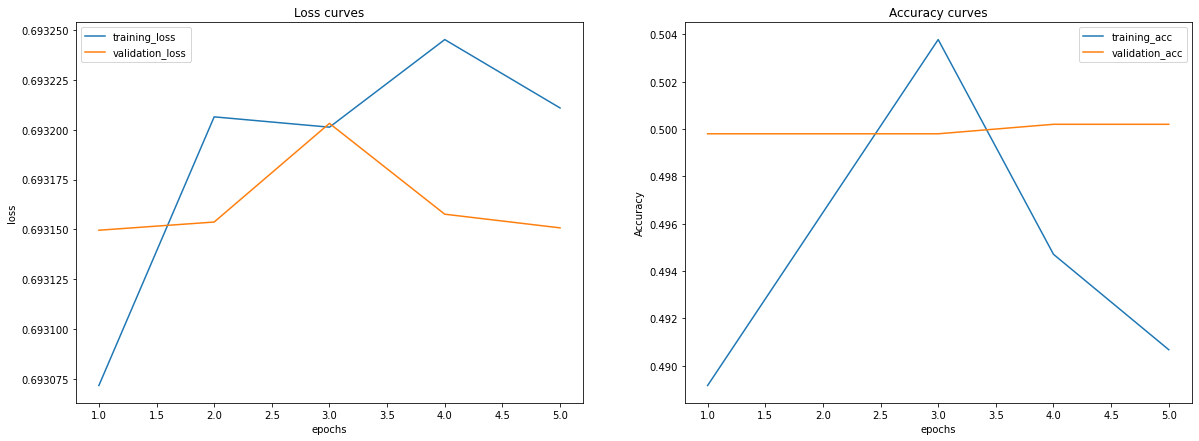

In [38]:
plot_loss_curves(history_simple_model_img_aug)

# What is Transfer learning?

Transfer learning is a machine learning method that reuses a trained model designed for a particular task to accomplish a different yet related task. The knowledge (pre-trained weights) acquired from task one is thereby transferred to the second model that focuses on the new task.

Using the [Efficient Net](http://keras.io/api/applications/efficientnet/#efficientnetb0-function)'s pre-trained weights to compensate for the model's small dataset and computation time. 

Note:  Most pre-trained models have their own specific kind of input prepreocessing, and it is worth looking into before using it. 
However, In this case, EfficientNet has implemented the required pre-processing into the model itself and doesnt require special attention.

# 3. Transfer Learning model

In [39]:
mixed_precision.set_global_policy('mixed_float16')

inputs=layers.Input(shape=(224,224,3),name='input_layer')

eff_net=keras.applications.efficientnet.EfficientNetB0(include_top=False)
eff_net.trainable=False

x = eff_net(inputs, training=False)
x=layers.GlobalAveragePooling2D(name='Global_Average_Pool_2D')(x)
outputs = layers.Dense(1, activation='sigmoid', name='Output_Layer')(x)

trans_model = keras.Model(inputs, outputs, name="Efficient_Net_Transfer_Learning")

2023-01-04 15:37:45.019688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 15:37:45.022572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


16719872/16705208 [==============================] - 0s 0us/step


In [40]:
trans_model.compile(optimizer=OPTIMIZER, loss=LOSS_FN, metrics=['accuracy'])

In [41]:
trans_model.summary()

Model: "Efficient_Net_Transfer_Learning"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
Global_Average_Pool_2D (Glob (None, 1280)              0         
_________________________________________________________________
Output_Layer (Dense)         (None, 1)                 1281      
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [42]:
history_trans_model = trans_model.fit(train_data, epochs=EPOCHS, steps_per_epoch=int(0.2*len(train_data)), 
                                           validation_data=test_data, validation_steps=len(test_data))

Epoch 1/5
 26/124 [=====>........................] - ETA: 5s - loss: 0.1680 - accuracy: 0.9519

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 87/124 [====================>.........] - ETA: 2s - loss: 0.0837 - accuracy: 0.9759

Cleanup called...


124/124 [==============================] - ETA: 0s - loss: 0.0670 - accuracy: 0.9803

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Cleanup called...


124/124 [==============================] - 23s 141ms/step - loss: 0.0670 - accuracy: 0.9803 - val_loss: 0.0406 - val_accuracy: 0.9862
Epoch 2/5
 48/124 [==========>...................] - ETA: 3s - loss: 0.0334 - accuracy: 0.9876

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 97/124 [======================>.......] - ETA: 1s - loss: 0.0333 - accuracy: 0.9894

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


105/124 [========================>.....] - ETA: 1s - loss: 0.0326 - accuracy: 0.9896

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


124/124 [==============================] - ETA: 0s - loss: 0.0320 - accuracy: 0.9894

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Cleanup called...


124/124 [==============================] - 15s 124ms/step - loss: 0.0320 - accuracy: 0.9894 - val_loss: 0.0350 - val_accuracy: 0.9888
Epoch 3/5
 23/124 [====>.........................] - ETA: 4s - loss: 0.0256 - accuracy: 0.9946

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 57/124 [============>.................] - ETA: 3s - loss: 0.0233 - accuracy: 0.9929

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 93/124 [=====================>........] - ETA: 1s - loss: 0.0240 - accuracy: 0.9929

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


114/124 [==========================>...] - ETA: 0s - loss: 0.0271 - accuracy: 0.9926

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


124/124 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 0.9917

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Cleanup called...


124/124 [==============================] - 16s 133ms/step - loss: 0.0272 - accuracy: 0.9917 - val_loss: 0.0324 - val_accuracy: 0.9890
Epoch 4/5
 11/124 [=>............................] - ETA: 5s - loss: 0.0232 - accuracy: 0.9886

Cleanup called...


 42/124 [=========>....................] - ETA: 3s - loss: 0.0259 - accuracy: 0.9896

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 52/124 [===========>..................] - ETA: 3s - loss: 0.0264 - accuracy: 0.9898

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


124/124 [==============================] - ETA: 0s - loss: 0.0282 - accuracy: 0.9902

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Cleanup called...


124/124 [==============================] - 16s 128ms/step - loss: 0.0282 - accuracy: 0.9902 - val_loss: 0.0309 - val_accuracy: 0.9890
Epoch 5/5
 16/124 [==>...........................] - ETA: 4s - loss: 0.0202 - accuracy: 0.9922

Cleanup called...


 42/124 [=========>....................] - ETA: 3s - loss: 0.0211 - accuracy: 0.9926

124/124 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.9919

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Cleanup called...


124/124 [==============================] - 15s 125ms/step - loss: 0.0231 - accuracy: 0.9919 - val_loss: 0.0307 - val_accuracy: 0.9896


In [43]:
trans_model_result = trans_model.evaluate(test_data)
trans_model_result

 18/156 [==>...........................] - ETA: 8s - loss: 0.0307 - accuracy: 0.9913

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


119/156 [=====================>........] - ETA: 2s - loss: 0.0322 - accuracy: 0.9890

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


150/156 [===========================>..] - ETA: 0s - loss: 0.0304 - accuracy: 0.9898

Cleanup called...


156/156 [==============================] - 9s 57ms/step - loss: 0.0307 - accuracy: 0.9896


[0.030715227127075195, 0.9895749688148499]

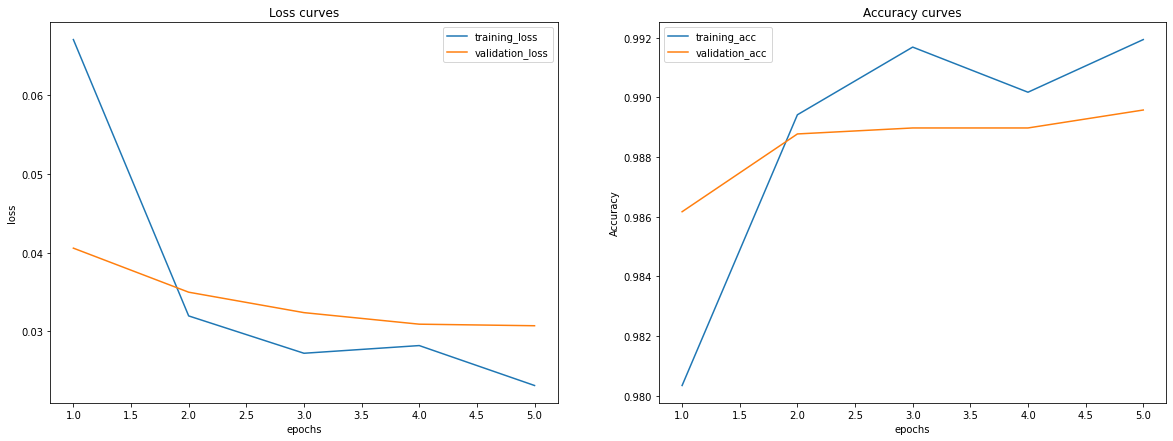

In [44]:
plot_loss_curves(history_trans_model)

**Best solution so far! Just out of curiosity , let's see if we can boost it with some data augmentation like before!**

# 4. Image augmentation + Transfer learning

In [45]:
data_augmentation=keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomRotation(0.2,fill_mode='nearest'),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
],name='Data_Augmentation_Layer')

In [46]:
mixed_precision.set_global_policy('mixed_float16')

inputs=layers.Input(shape=(224,224,3),name='input_layer')

base_model=keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable=False

x=data_augmentation(inputs)

x=base_model(x,training=False)

x=layers.GlobalAveragePooling2D(name='Global_Average_Pool_2D')(x)

outputs=layers.Dense(1,activation='sigmoid',dtype='float32',name="Output_layer")(x)

trans_model_data_aug=keras.Model(inputs,outputs,name="model")

In [47]:
trans_model_data_aug.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
Data_Augmentation_Layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
Global_Average_Pool_2D (Glob (None, 1280)              0         
_________________________________________________________________
Output_layer (Dense)         (None, 1)                 1281      
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [48]:
trans_model_data_aug.compile( loss=LOSS_FN, metrics=['accuracy'])

In [49]:
history_trans_model_data_aug=trans_model_data_aug.fit(train_data,epochs=EPOCHS,steps_per_epoch=int (0.2*len(train_data)),
                                                      validation_data=test_data,validation_steps=len(test_data))

Epoch 1/5
 23/124 [====>.........................] - ETA: 15s - loss: 0.4437 - accuracy: 0.8438

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 83/124 [===================>..........] - ETA: 4s - loss: 0.2814 - accuracy: 0.9100

Cleanup called...


124/124 [==============================] - ETA: 0s - loss: 0.2357 - accuracy: 0.9262

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Cleanup called...


124/124 [==============================] - 29s 185ms/step - loss: 0.2357 - accuracy: 0.9262 - val_loss: 0.0761 - val_accuracy: 0.9804
Epoch 2/5
 44/124 [=========>....................] - ETA: 7s - loss: 0.1208 - accuracy: 0.9609

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 94/124 [=====================>........] - ETA: 2s - loss: 0.1183 - accuracy: 0.9578

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


101/124 [=======================>......] - ETA: 1s - loss: 0.1168 - accuracy: 0.9585

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


124/124 [==============================] - ETA: 0s - loss: 0.1171 - accuracy: 0.9579

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Cleanup called...


124/124 [==============================] - 19s 155ms/step - loss: 0.1171 - accuracy: 0.9579 - val_loss: 0.0538 - val_accuracy: 0.9840
Epoch 3/5
 19/124 [===>..........................] - ETA: 7s - loss: 0.1104 - accuracy: 0.9556

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 53/124 [===========>..................] - ETA: 5s - loss: 0.1006 - accuracy: 0.9611

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 90/124 [====================>.........] - ETA: 2s - loss: 0.1035 - accuracy: 0.9583

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


113/124 [==========================>...] - ETA: 0s - loss: 0.1031 - accuracy: 0.9596

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


124/124 [==============================] - ETA: 0s - loss: 0.1027 - accuracy: 0.9594

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Cleanup called...


124/124 [==============================] - 17s 141ms/step - loss: 0.1027 - accuracy: 0.9594 - val_loss: 0.0458 - val_accuracy: 0.9856
Epoch 4/5
 16/124 [==>...........................] - ETA: 7s - loss: 0.0895 - accuracy: 0.9766

Cleanup called...


 39/124 [========>.....................] - ETA: 5s - loss: 0.0897 - accuracy: 0.9655

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 50/124 [===========>..................] - ETA: 5s - loss: 0.0917 - accuracy: 0.9638

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


124/124 [==============================] - ETA: 0s - loss: 0.0999 - accuracy: 0.9551

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Cleanup called...


124/124 [==============================] - 18s 143ms/step - loss: 0.0999 - accuracy: 0.9551 - val_loss: 0.0420 - val_accuracy: 0.9872
Epoch 5/5
 25/124 [=====>........................] - ETA: 7s - loss: 0.0782 - accuracy: 0.9675

Cleanup called...


 45/124 [=========>....................] - ETA: 5s - loss: 0.0832 - accuracy: 0.9694

124/124 [==============================] - ETA: 0s - loss: 0.0894 - accuracy: 0.9645

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Cleanup called...


124/124 [==============================] - 17s 139ms/step - loss: 0.0894 - accuracy: 0.9645 - val_loss: 0.0430 - val_accuracy: 0.9860


In [50]:
trans_model_data_aug_results = trans_model_data_aug.evaluate(test_data)

 19/156 [==>...........................] - ETA: 7s - loss: 0.0554 - accuracy: 0.9819

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


119/156 [=====================>........] - ETA: 2s - loss: 0.0467 - accuracy: 0.9835

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


150/156 [===========================>..] - ETA: 0s - loss: 0.0428 - accuracy: 0.9856

Cleanup called...


156/156 [==============================] - 9s 56ms/step - loss: 0.0430 - accuracy: 0.9860


In [51]:
trans_model_data_aug_results

[0.043001819401979446, 0.9859663248062134]

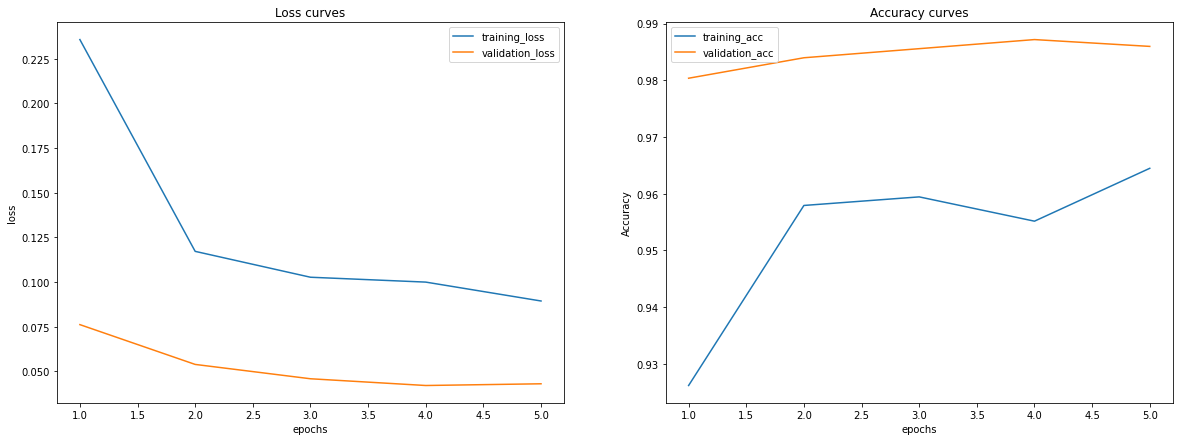

In [52]:
plot_loss_curves(history_trans_model_data_aug)

In [53]:
def plot_all(history_list):
    for name ,hist in history_list.items():
        plot_loss_curves(hist)
        plt.suptitle(name)

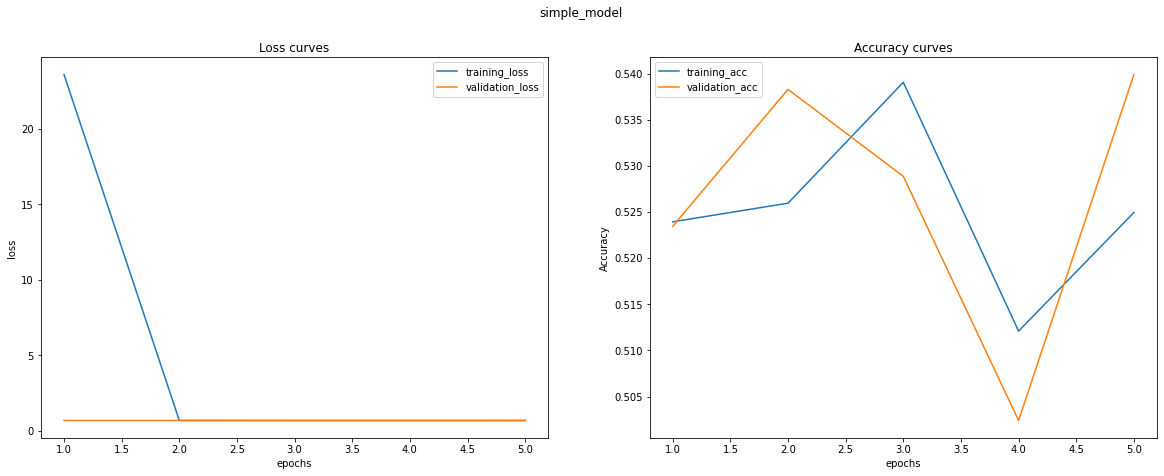

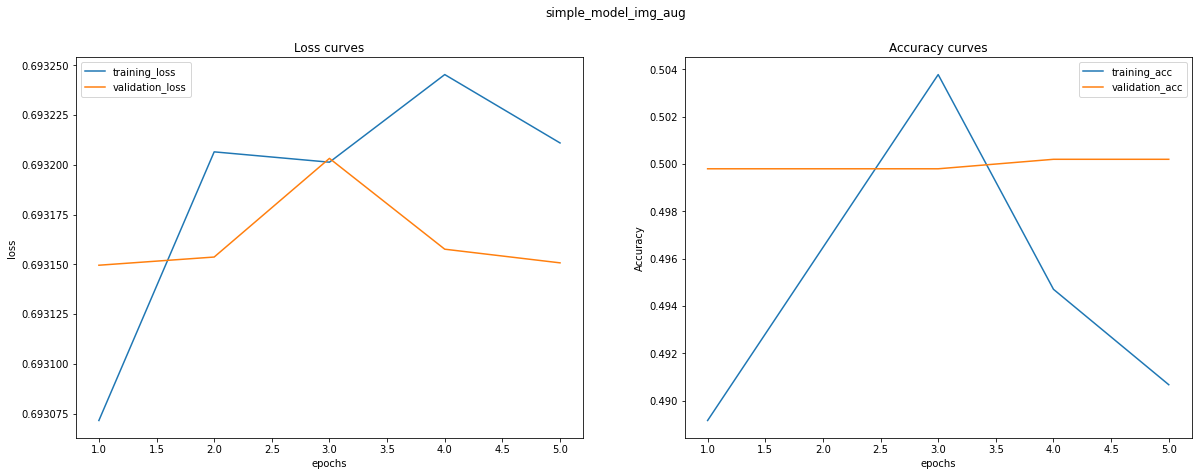

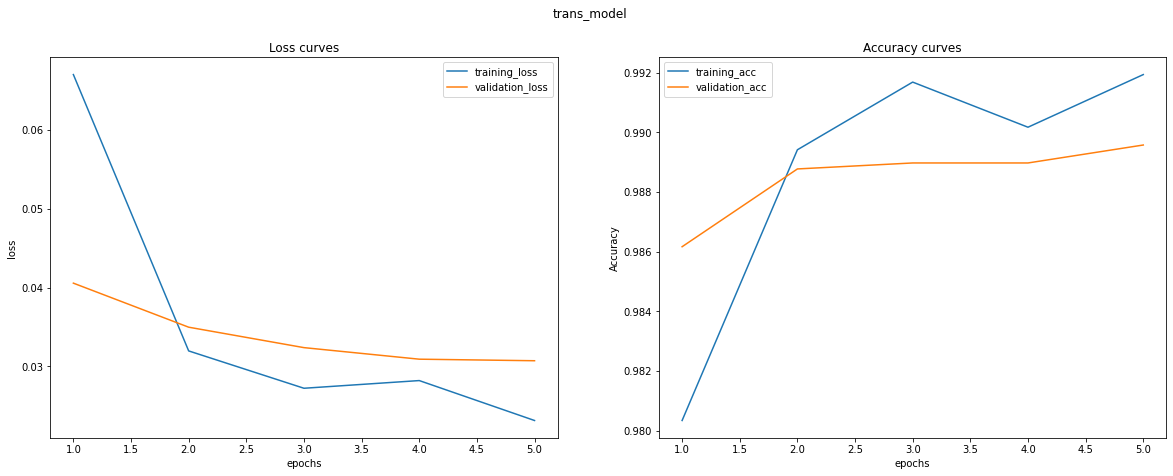

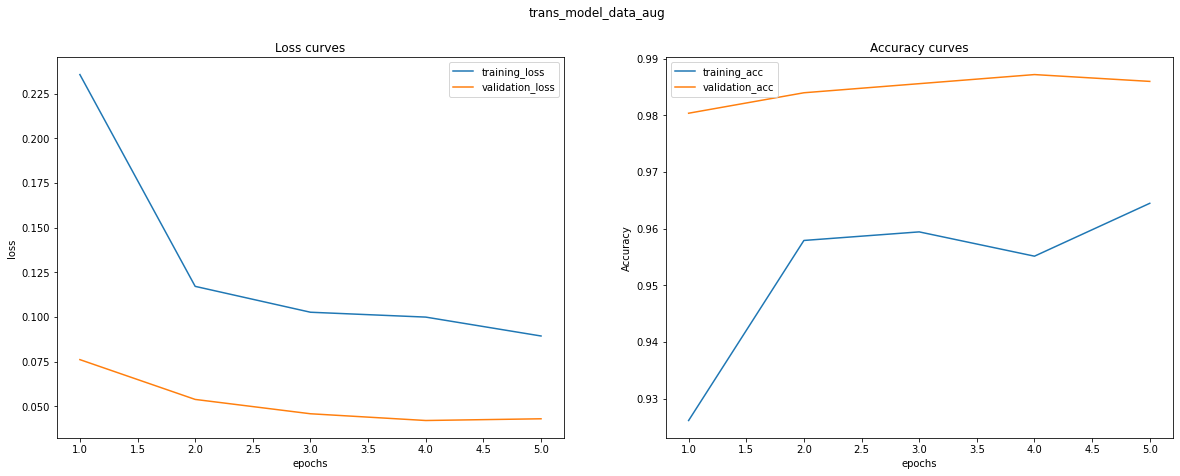

In [54]:
histories = {'simple_model':history_simple_model, 'simple_model_img_aug':history_simple_model_img_aug,
             'trans_model':history_trans_model, 'trans_model_data_aug':history_trans_model_data_aug}

plot_all(histories)

In [55]:
def evaluation_results(results):
    for name ,result in results.items():
        print('Model Name: ',name,'\n')
        print('Loss: {} \tAccuracy: {}\n'.format(result[0], result[1]))

In [56]:
evaluation_results_v1 = {'simple_DL_model': simple_DL_model_results, 'simple_DL_model_img_aug': simple_DL_model_img_aug_results,
                         'transfer_learning_model': trans_model_result, 'transfer_learning_model_data_aug': trans_model_data_aug_results}

# Model Performance with Dataset 1

In [57]:
evaluation_results(evaluation_results_v1)

Model Name:  simple_DL_model 

Loss: 0.6934595108032227 	Accuracy: 0.53989577293396

Model Name:  simple_DL_model_img_aug 

Loss: 0.6931507587432861 	Accuracy: 0.5002005100250244

Model Name:  transfer_learning_model 

Loss: 0.030715227127075195 	Accuracy: 0.9895749688148499

Model Name:  transfer_learning_model_data_aug 

Loss: 0.043001819401979446 	Accuracy: 0.9859663248062134



## The Model that uses Transfer Learning fairs better than the basic CNNs and fairs slightly better with the help of an image augmentation layer as it helps the model generalize better with the validation data.

# Explore Dataset 2: [Cats and Dogs](http://www.kaggle.com/datasets/chetankv/dogs-cats-images)
The dataset is already split into train and test directories

In [58]:
train_dir = '../input/dogs-cats-images/dataset/training_set'
test_dir = '../input/dogs-cats-images/dataset/test_set'

In [59]:
img_size = (224,224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir, label_mode='binary', image_size=img_size)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode='binary', image_size=img_size, shuffle=False)

Found 8000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [60]:
class_names = train_data.class_names
class_names

['cats', 'dogs']

In [61]:
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

# 1. Simple DL model with the new dataset

In [62]:
history_simple_model_v2 = simple_DL_model.fit(train_data, epochs=EPOCHS, steps_per_epoch=int(0.2*len(train_data)), 
                                           validation_data=test_data, validation_steps=len(test_data))

Epoch 1/5
50/50 [==============================] - 22s 411ms/step - loss: 0.6926 - accuracy: 0.5181 - val_loss: 0.6898 - val_accuracy: 0.5115
Epoch 2/5
50/50 [==============================] - 12s 253ms/step - loss: 0.7035 - accuracy: 0.5150 - val_loss: 0.6838 - val_accuracy: 0.5445
Epoch 3/5
50/50 [==============================] - 12s 247ms/step - loss: 0.6857 - accuracy: 0.5519 - val_loss: 0.7578 - val_accuracy: 0.5315
Epoch 4/5
50/50 [==============================] - 16s 335ms/step - loss: 0.6914 - accuracy: 0.5344 - val_loss: 0.6878 - val_accuracy: 0.5425
Epoch 5/5
50/50 [==============================] - 9s 176ms/step - loss: 0.6890 - accuracy: 0.5456 - val_loss: 0.6888 - val_accuracy: 0.5280


In [63]:
simple_model_v2_results = simple_DL_model.evaluate(test_data)

63/63 [==============================] - 4s 62ms/step - loss: 0.6888 - accuracy: 0.5280


# 2. Simple DL model + image augmentation with new dataset

In [64]:
history_simple_model_img_aug_v2 = simple_DL_model_img_aug.fit(train_data, epochs=EPOCHS, steps_per_epoch=int(0.2*len(train_data)), 
                                           validation_data=test_data, validation_steps=len(test_data))

Epoch 1/5
50/50 [==============================] - 8s 155ms/step - loss: 0.6929 - accuracy: 0.5231 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
50/50 [==============================] - 8s 164ms/step - loss: 0.6932 - accuracy: 0.5038 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
50/50 [==============================] - 8s 154ms/step - loss: 0.6933 - accuracy: 0.4931 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
50/50 [==============================] - 8s 161ms/step - loss: 0.6933 - accuracy: 0.4875 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
50/50 [==============================] - 7s 135ms/step - loss: 0.6932 - accuracy: 0.4900 - val_loss: 0.6931 - val_accuracy: 0.5000


In [65]:
simple_model_img_aug_v2_results = simple_DL_model_img_aug.evaluate(test_data)

63/63 [==============================] - 4s 61ms/step - loss: 0.6931 - accuracy: 0.5000


# 3. Transfer learning model with new dataset

In [66]:
history_trans_model_v2 = trans_model.fit(train_data, epochs=EPOCHS, steps_per_epoch=int(0.2*len(train_data)), 
                                           validation_data=test_data, validation_steps=len(test_data))

Epoch 1/5
50/50 [==============================] - 9s 174ms/step - loss: 0.0244 - accuracy: 0.9894 - val_loss: 0.0247 - val_accuracy: 0.9915
Epoch 2/5
50/50 [==============================] - 8s 163ms/step - loss: 0.0220 - accuracy: 0.9912 - val_loss: 0.0242 - val_accuracy: 0.9915
Epoch 3/5
50/50 [==============================] - 8s 162ms/step - loss: 0.0203 - accuracy: 0.9919 - val_loss: 0.0241 - val_accuracy: 0.9915
Epoch 4/5
50/50 [==============================] - 8s 163ms/step - loss: 0.0188 - accuracy: 0.9944 - val_loss: 0.0238 - val_accuracy: 0.9935
Epoch 5/5
50/50 [==============================] - 7s 145ms/step - loss: 0.0232 - accuracy: 0.9919 - val_loss: 0.0244 - val_accuracy: 0.9925


In [67]:
trans_model_v2_results = trans_model.evaluate(test_data)

63/63 [==============================] - 4s 67ms/step - loss: 0.0244 - accuracy: 0.9925


# 4 .Transfer learning model + image augmentation with new dataset

In [68]:
history_trans_model_data_aug_v2=trans_model_data_aug.fit(train_data,epochs=EPOCHS,steps_per_epoch=int (0.2*len(train_data)),
                                                         validation_data=test_data,validation_steps=len(test_data))

Epoch 1/5
50/50 [==============================] - 9s 172ms/step - loss: 0.0882 - accuracy: 0.9594 - val_loss: 0.0324 - val_accuracy: 0.9905
Epoch 2/5
50/50 [==============================] - 8s 170ms/step - loss: 0.0787 - accuracy: 0.9737 - val_loss: 0.0326 - val_accuracy: 0.9905
Epoch 3/5
50/50 [==============================] - 9s 174ms/step - loss: 0.0892 - accuracy: 0.9613 - val_loss: 0.0314 - val_accuracy: 0.9915
Epoch 4/5
50/50 [==============================] - 9s 172ms/step - loss: 0.0960 - accuracy: 0.9638 - val_loss: 0.0317 - val_accuracy: 0.9905
Epoch 5/5
50/50 [==============================] - 8s 156ms/step - loss: 0.0828 - accuracy: 0.9706 - val_loss: 0.0316 - val_accuracy: 0.9900


In [69]:
trans_model_data_aug_v2_results = trans_model_data_aug.evaluate(test_data)

63/63 [==============================] - 6s 93ms/step - loss: 0.0316 - accuracy: 0.9900


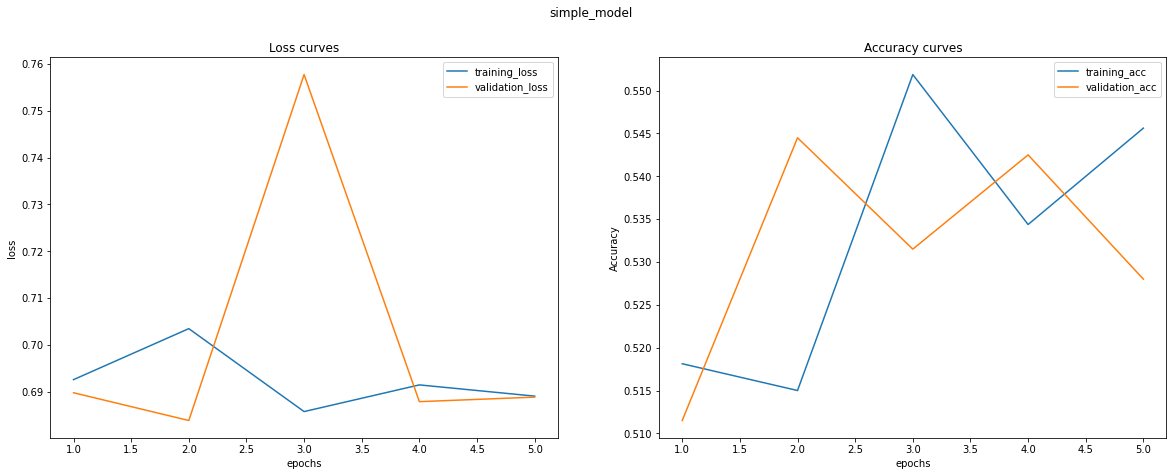

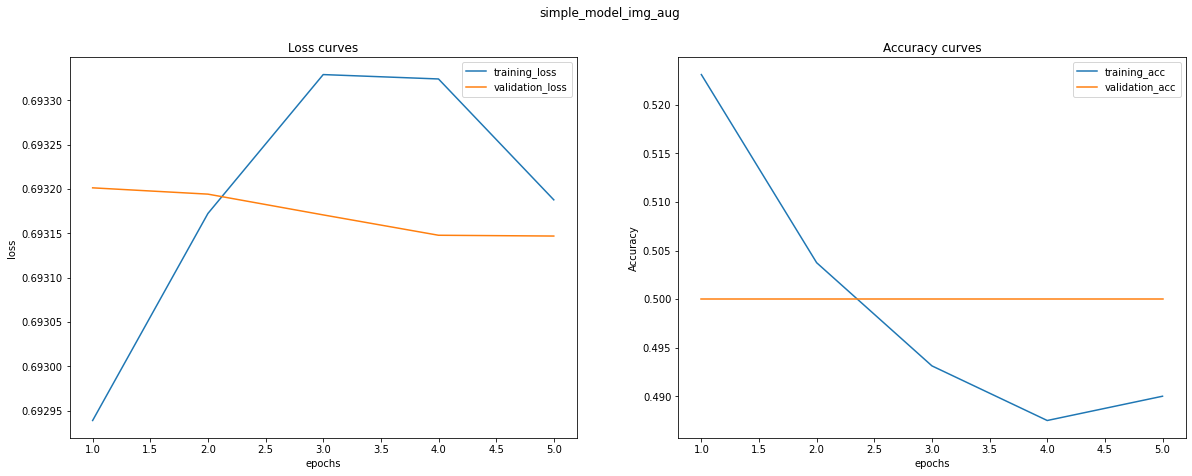

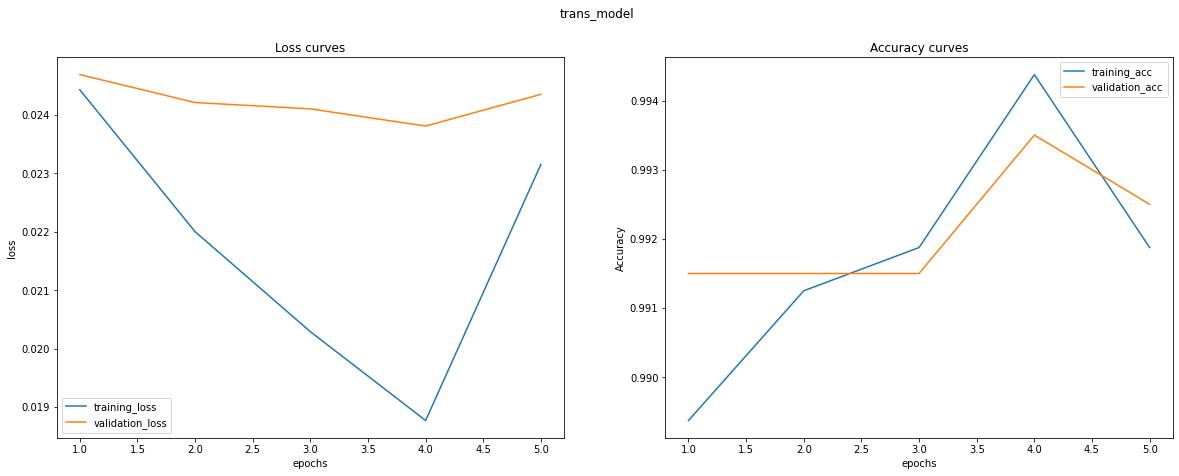

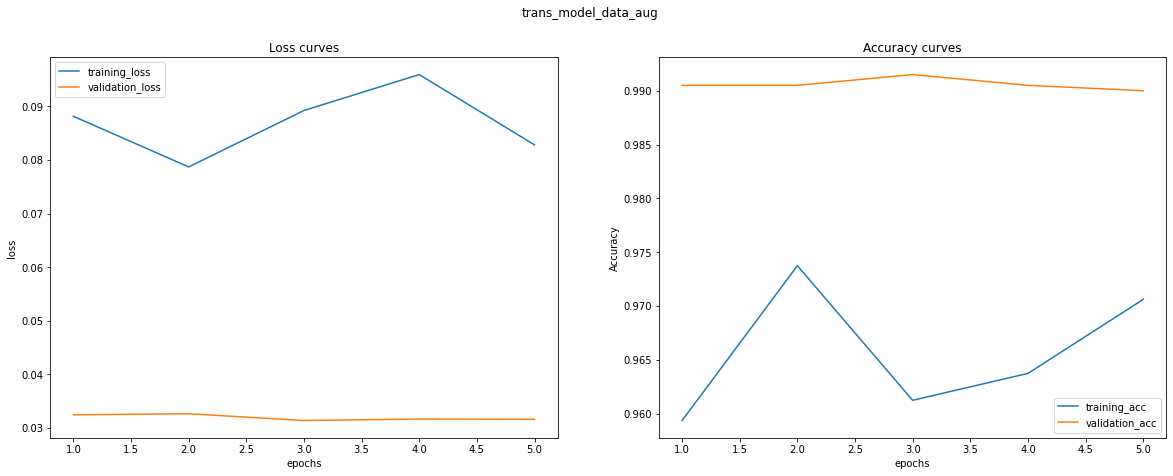

In [70]:
histories_v2 = {'simple_model':history_simple_model_v2, 'simple_model_img_aug':history_simple_model_img_aug_v2,
             'trans_model':history_trans_model_v2, 'trans_model_data_aug':history_trans_model_data_aug_v2}

plot_all(histories_v2)

In [71]:
evaluation_results_v2 = {'simple_DL_model': simple_model_v2_results, 'simple_DL_model_img_aug': simple_model_img_aug_v2_results,
                         'transfer_learning_model': trans_model_v2_results, 'transfer_learning_model_data_aug': trans_model_data_aug_v2_results}

# Compare Model Performance with both Datasets 1 & 2

In [72]:
evaluation_results(evaluation_results_v1)

Model Name:  simple_DL_model 

Loss: 0.6934595108032227 	Accuracy: 0.53989577293396

Model Name:  simple_DL_model_img_aug 

Loss: 0.6931507587432861 	Accuracy: 0.5002005100250244

Model Name:  transfer_learning_model 

Loss: 0.030715227127075195 	Accuracy: 0.9895749688148499

Model Name:  transfer_learning_model_data_aug 

Loss: 0.043001819401979446 	Accuracy: 0.9859663248062134



In [73]:
evaluation_results(evaluation_results_v2)

Model Name:  simple_DL_model 

Loss: 0.6888197660446167 	Accuracy: 0.527999997138977

Model Name:  simple_DL_model_img_aug 

Loss: 0.6931470632553101 	Accuracy: 0.5

Model Name:  transfer_learning_model 

Loss: 0.024351852014660835 	Accuracy: 0.9925000071525574

Model Name:  transfer_learning_model_data_aug 

Loss: 0.03162221238017082 	Accuracy: 0.9900000095367432



**A few observations**,
* a simple CNN can deliver a decent 50% accuracy, however, the loss stays the same even with the help of Image Augmentation on both the datasets.
* a highly complex Efficient Net used out of the box with almost no fine-tuning performs extremely well in both the different datasets. Infact, the Data Augmentation layer hurts the metrics slighlty. 

**Thus, reinforcing the idea, that data dictates the architecture of the model and experimentation is always key to finding the right balance between an efficient model and an over kill of a model.**